In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import funcs.utils as utils
import funcs.plotting as plot
import funcs.amyloid as amyloid

# ML Imports

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

import shap

In [2]:
PROCESSED_DIR = "data/processed"

## 1. Load Data
---

In [3]:
# Raw Data
data_df = pd.read_csv(os.path.join(PROCESSED_DIR, "AL_with_ccp_03.tsv"), sep='\t', index_col=0).rename(columns=amyloid.ddict_unclean)

# Fix Dates
data_df = pd.concat([pd.to_datetime(data_df[amyloid.dates][var], format="mixed") for var in amyloid.dates], axis=1, keys=amyloid.dates).join(
    data_df.drop(amyloid.dates, axis=1)  
)

In [4]:
Xi_mice = pd.read_csv("data/imputed/full_dataset/mice_qvars_02.tsv", sep="\t")
Xi_mice = Xi_mice.loc[Xi_mice.join(data_df['fna3_cluster_n']).dropna(subset='fna3_cluster_n').index]

In [5]:
# Drop due to high missingness
to_drop = ["Amyloid type","Secondary organ","Arrhythmia ","(Autonomic)",
           "(Peripheral)","SIFE M-component","UIFE M-component",
           "Education","Abdominal fat pad CR staining", "Bone marrow CR staining"]

# Create dataset
Xi_mice_bu_df = utils.data_formatter(
    Xi_mice.join(data_df.loc[Xi_mice.index, amyloid.catvars]).drop(columns=to_drop).dropna()
)

# Filtered dataset (for complete categoricals)
y = data_df.loc[Xi_mice_bu_df.index, 'fna3_cluster_n'].map({'Low':0,'Intermediate':1, 'High': 2})
X = Xi_mice_bu_df.copy()

# Full dataset
Xi_mice_scaled = pd.DataFrame(StandardScaler().fit_transform(Xi_mice.values), index=Xi_mice.index, columns=Xi_mice.columns)
y_full = data_df.loc[Xi_mice.index, 'fna3_cluster_n'].map({'Low':0,'Intermediate':1, 'High': 2})

Using 29 quantitative variables.
Using 33 categorical variables.
Total samples x feaures (one-hot encoded): (1599 x 71)


## 2. Modeling
---

In [6]:
# Initial model just with quantitative variables
test_size = 0.2

NJOBS = -1

# Random state
RANDOM_STATE = 122

# 
CV = 5

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(
#     Xi_mice_bu_df, y, 
#     test_size=test_size, random_state=RANDOM_STATE)

# print("Train size (n={})".format(X_train.shape[0]))
# print("Test size (n={})".format(X_test.shape[0]))

In [8]:
models = dict()
param_grids = dict()
grid_searches = dict()

# Naive Bayes
param_grids["nb"] = {'var_smoothing': np.logspace(0,-9, num=100)}
models["nb"] = GaussianNB()

# KNN
param_grids["knn"] = {
    'n_neighbors': [3, 5,10,15],
    'weights': ['uniform','distance'],
    'metric': ['minkowski']
}
models["knn"] = KNeighborsClassifier()

# Random Forest
param_grids["rf"] = {
    'n_estimators': range(100,1000,100),
    'max_depth': [5, 10, 15, 20, 25],
    'criterion':["gini","entropy"],
}
models["rf"] = BalancedRandomForestClassifier(sampling_strategy="all", replacement=True, bootstrap=False)

# XGBoost
param_grids["xgb"] = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(100,1000,100),
    'learning_rate': [0.1, 0.01, 0.001],
}
models["xgb"] = XGBClassifier(objective= 'multi:softmax', nthread=8, seed=RANDOM_STATE)

In [9]:
# rfb = RandomForestClassifier(
#     class_weight='balanced_subsample', criterion='entropy',
#     max_features=0.10999925914892408, min_samples_leaf=4,
#     n_estimators=65, n_jobs=-1, random_state=1,
#     verbose=False)

#rfb.fit(Xi_mice_scaled, y_full)
# best_models = dict()
# best_models['rf_hyperopt'] = rfb

In [10]:
best_models = dict()

for key in models.keys():
    grid_searches[key] = GridSearchCV(models[key], param_grid=param_grids[key], cv=CV, n_jobs=NJOBS)
    grid_searches[key].fit(Xi_mice_scaled, y_full)
    best_models[key] = grid_searches[key].best_estimator_

In [47]:
def crossValScore(
        X: pd.DataFrame, 
        y: pd.DataFrame, 
        models: dict, 
        folds: int = 5, 
        random_state: int = 42):
    """Cross validation scoring.

    Args:
        X (pd.DataFrame): _description_
        y (pd.DataFrame): _description_
        models (dict): _description_
        folds (int, optional): _description_. Defaults to 5.
        random_state (int, optional): _description_. Defaults to 42.

    Returns:
        _type_: _description_
    """
    from sklearn.model_selection import KFold
    from sklearn.metrics import classification_report
    from sklearn.metrics import cohen_kappa_score

    # Initialize fold split
    kf = KFold(n_splits=folds, shuffle=True, random_state=random_state)

    # Results
    results_df = list()

    for key in models.keys():
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            models[key].fit(X.iloc[train_index,:], y.iloc[train_index])
            y_pred = models[key].predict(X.iloc[test_index,:])

            # Generate classificaiton report
            cr = classification_report(y.iloc[test_index], y_pred, output_dict=True)
            cr = pd.DataFrame.from_dict(cr).drop(
                columns=['macro avg','weighted avg'], 
                index=['support']).reset_index()
            
            # Add kappa score
            cr['kappa'] = cohen_kappa_score(y.iloc[test_index], y_pred)

            # Naming
            cr['Classifier'] = key
            cr['k'] = i
            cr = cr.rename(columns={'index':'metric'})

            results_df.append(cr)
    
    return pd.concat(results_df)

In [57]:
from sklearn.preprocessing import MinMaxScaler

Xi_mice_scaled_minmax = pd.DataFrame(
    MinMaxScaler().fit_transform(Xi_mice_scaled),
    index=Xi_mice_scaled.index,
    columns=Xi_mice_scaled.columns
)

In [58]:
results_df = crossValScore(
    Xi_mice_scaled_minmax, 
    y_full, 
    best_models,
    random_state=RANDOM_STATE
)

In [59]:
results_df.groupby(['Classifier','metric']).agg(['mean','std'])

0                   1                   2  \
                           mean       std      mean       std      mean   
Classifier  metric                                                        
rf_hyperopt f1-score   0.862216  0.017450  0.867703  0.013280  0.821196   
            precision  0.870451  0.018845  0.863003  0.015093  0.814646   
            recall     0.854268  0.020051  0.873008  0.026879  0.830971   

                                accuracy               kappa              k  \
                            std     mean       std      mean       std mean   
Classifier  metric                                                            
rf_hyperopt f1-score   0.025563   0.8568  0.008731  0.774328  0.013989  2.0   
            precision  0.051658   0.8568  0.008731  0.774328  0.013989  2.0   
            recall     0.042818   0.8568  0.008731  0.774328  0.013989  2.0   

                                 
                            std  
Classifier  metric               
rf_hyperopt f1-score   1.581139  
            precision  1.581139  
            recall     1.581139

In [62]:
results_df.groupby(['Classifier','metric']).agg(['mean','std']).sort_values(("accuracy","mean"))

0                   1                   2  \
                           mean       std      mean       std      mean   
Classifier  metric                                                        
rf_hyperopt f1-score   0.862216  0.017450  0.867703  0.013280  0.821196   
            precision  0.870451  0.018845  0.863003  0.015093  0.814646   
            recall     0.854268  0.020051  0.873008  0.026879  0.830971   

                                accuracy               kappa              k  \
                            std     mean       std      mean       std mean   
Classifier  metric                                                            
rf_hyperopt f1-score   0.025563   0.8568  0.008731  0.774328  0.013989  2.0   
            precision  0.051658   0.8568  0.008731  0.774328  0.013989  2.0   
            recall     0.042818   0.8568  0.008731  0.774328  0.013989  2.0   

                                 
                            std  
Classifier  metric               
rf_hyperopt f1-score   1.581139  
            precision  1.581139  
            recall     1.581139

In [128]:
results_df.groupby(['Classifier','k','metric']).std(ddof=0)

0    1    2  accuracy  kappa
Classifier k metric                                   
knn        0 f1-score   0.0  0.0  0.0       0.0    0.0
             precision  0.0  0.0  0.0       0.0    0.0
             recall     0.0  0.0  0.0       0.0    0.0
             support    0.0  0.0  0.0       0.0    0.0
           1 f1-score   0.0  0.0  0.0       0.0    0.0
...                     ...  ...  ...       ...    ...
xgb        3 support    0.0  0.0  0.0       0.0    0.0
           4 f1-score   0.0  0.0  0.0       0.0    0.0
             precision  0.0  0.0  0.0       0.0    0.0
             recall     0.0  0.0  0.0       0.0    0.0
             support    0.0  0.0  0.0       0.0    0.0

[80 rows x 5 columns]

Fold 0:
(1653,) (414,)
Fold 1:
(1653,) (414,)
Fold 2:
(1654,) (413,)
Fold 3:
(1654,) (413,)
Fold 4:
(1654,) (413,)


In [68]:
k[1]

TypeError: 'int' object is not subscriptable

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [35]:
cross_val_score(
    grid_searches[key].best_estimator_,
    Xi_mice_scaled, 
    y_full, 
    scoring="recall", 
    cv=CV
    )

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shankaraanand/anaconda3/envs/r4/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/shankaraanand/anaconda3/envs/r4/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/shankaraanand/anaconda3/envs/r4/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/shankaraanand/anaconda3/envs/r4/lib/python3.11/site-packages/sklearn/metrics/_classification.py", line 2304, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
             

array([nan, nan, nan, nan, nan])

In [ ]:
models["nb"].score(Xi_mice_scaled, y_full)

0.8021286889211418

In [21]:
grid_searches[key].best_estimator_.fit(Xi_mice_scaled, y_full)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [3]:
#pd.DataFrame.from_dict(grid_searches["xgb"].cv_results_).sort_values("rank_test_score")

NameError: name 'grid_searches' is not defined

In [167]:
param_dist = {'n_estimators': range(100,1000,100),
              'max_depth': [5,10,15,20,25],
              'criterion':["gini","entropy"],
              }

# Create a random forest classifier
rf = BalancedRandomForestClassifier(sampling_strategy="all", replacement=True, bootstrap=False)

# Use random search to find the best hyperparameters
rand_search = GridSearchCV(rf, param_grid=param_dist, cv=5, n_jobs=NJOBS)

rand_search.fit(X_train, y_train)
print('Best hyperparameters:',  rand_search.best_params_)
best_rf = rand_search.best_estimator_

KeyboardInterrupt: 

In [161]:
pd.DataFrame.from_dict(rand_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.225300,0.005853,0.056838,0.084658,200,10,entropy,"{'n_estimators': 200, 'max_depth': 10, 'criter...",0.867188,0.847656,0.863281,0.812500,0.874510,0.853027,0.022084,2
1,0.738120,0.003290,0.051889,0.001002,700,5,gini,"{'n_estimators': 700, 'max_depth': 5, 'criteri...",0.843750,0.828125,0.843750,0.792969,0.858824,0.833483,0.022464,4
2,0.477305,0.038604,0.034647,0.010249,400,5,entropy,"{'n_estimators': 400, 'max_depth': 5, 'criteri...",0.855469,0.828125,0.843750,0.792969,0.843137,0.832690,0.021675,5
3,0.336821,0.003169,0.027282,0.000137,300,25,entropy,"{'n_estimators': 300, 'max_depth': 25, 'criter...",0.875000,0.863281,0.871094,0.804688,0.874510,0.857714,0.026843,1
4,0.559804,0.015600,0.039358,0.001456,500,25,gini,"{'n_estimators': 500, 'max_depth': 25, 'criter...",0.847656,0.847656,0.867188,0.808594,0.874510,0.849121,0.022881,3


In [56]:
def comp_matrix(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Accuracy: 0.9749804534792806
Precision: 0.976127279694409
Recall: 0.9749804534792806


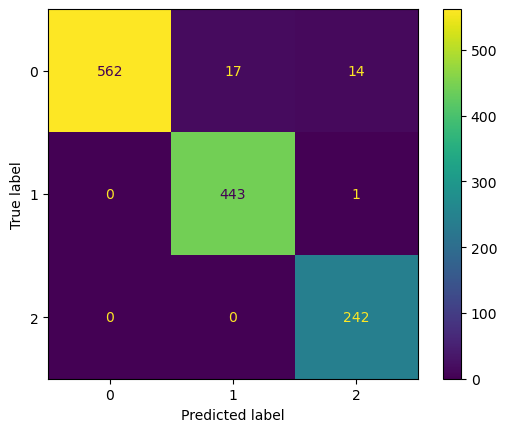

In [57]:
comp_matrix(best_rf.predict(X_train), y_train)

Accuracy: 0.8375
Precision: 0.8526518103575741
Recall: 0.8375


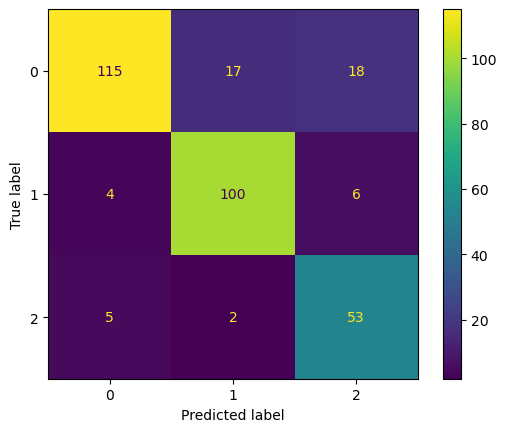

In [58]:
comp_matrix(best_rf.predict(X_test), y_test)

In [103]:
features_df = pd.DataFrame(best_rf.feature_importances_,best_rf.feature_names_in_, columns=["importance"])
features_df["std"] = np.std([best_rf.feature_importances_ for tree in best_rf.estimators_], axis=0)

In [104]:
features_df

,importance,std
Sex=male,0.002026,3.512815e-17
Ethnicity=non_hispanic,0.000523,4.445229e-18
Race=Black,0.001223,2.385245e-18
Race=Other,0.000429,3.903128e-18
Race=White,0.001493,2.168404e-19
...,...,...
TIBC,0.076358,8.881784e-16
Systolic_BP_sitting,0.072565,5.134781e-16
Diastolic_BP_sitting,0.042268,6.591949e-16
Pulse_sitting,0.015289,1.665335e-16


In [123]:
features_df = features_df

,importance,std
Sex=male,0.002026,3.512815e-17
Ethnicity=non_hispanic,0.000523,4.445229e-18
Race=Black,0.001223,2.385245e-18
Race=Other,0.000429,3.903128e-18
Race=White,0.001493,2.168404e-19
...,...,...
TIBC,0.076358,8.881784e-16
Systolic BP sitting,0.072565,5.134781e-16
Diastolic BP sitting,0.042268,6.591949e-16
Pulse sitting,0.015289,1.665335e-16


array([3.46944695e-16, 2.84494650e-16, 2.18575158e-16, 1.71737624e-16,
       2.06432094e-16, 1.17961196e-16, 2.01227923e-16, 9.71445147e-17,
       4.02455846e-16, 2.15105711e-16, 1.04083409e-16, 1.19695920e-16,
       7.11236625e-17, 1.52655666e-16, 1.22124533e-15, 2.28983499e-16,
       2.09901541e-16, 3.05311332e-16, 3.46944695e-16, 3.98986399e-17,
       3.95516953e-16, 6.59194921e-17, 3.12250226e-17, 1.43982049e-16,
       2.28983499e-16, 1.75207071e-16, 8.88178420e-16, 5.13478149e-16,
       6.59194921e-16, 1.66533454e-16, 1.59594560e-16])

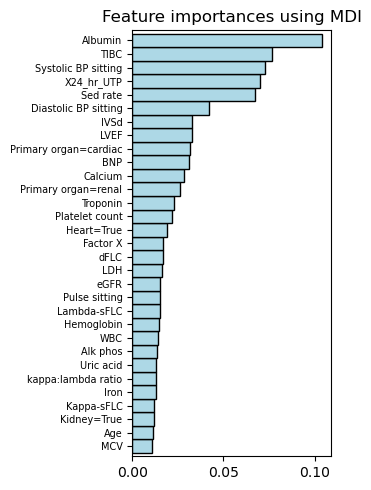

In [140]:
min_importance = 0.01
figsize=(4,5)

fig, ax = plt.subplots(figsize=figsize)

features_df[features_df['importance']>0.01]['importance'].sort_values(ascending=True).rename(
    index=amyloid.ddict_unclean).plot.barh(
        ax=ax, width=1, edgecolor='k', color='lightblue')
ax.set_title("Feature importances using MDI")
fig.tight_layout()

_ = ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)

In [141]:
shap_explainers = shap.Explainer(best_rf.predict, X_train)
shap_values = shap_explainers(X_train)

PermutationExplainer explainer: 1280it [15:41,  1.34it/s]                          


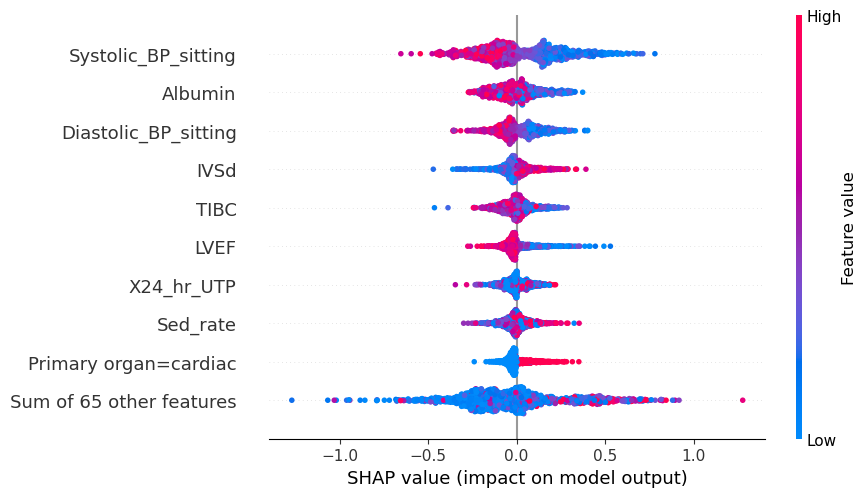

In [142]:
shap.plots.beeswarm(shap_values)

In [80]:
shap.plots.beeswarm(shap_low_values, show=False)

TypeError: The beeswarm plot requires an `Explanation` object as the `shap_values` argument.

<Axes: xlabel='SHAP value (impact on model output)'>

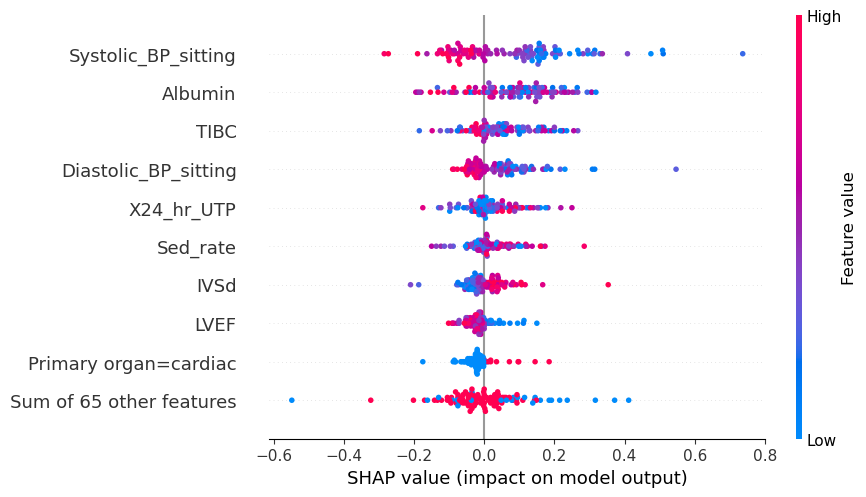

In [72]:
shap.plots.beeswarm(shap_intermediate_values, show=False)

<Axes: xlabel='SHAP value (impact on model output)'>

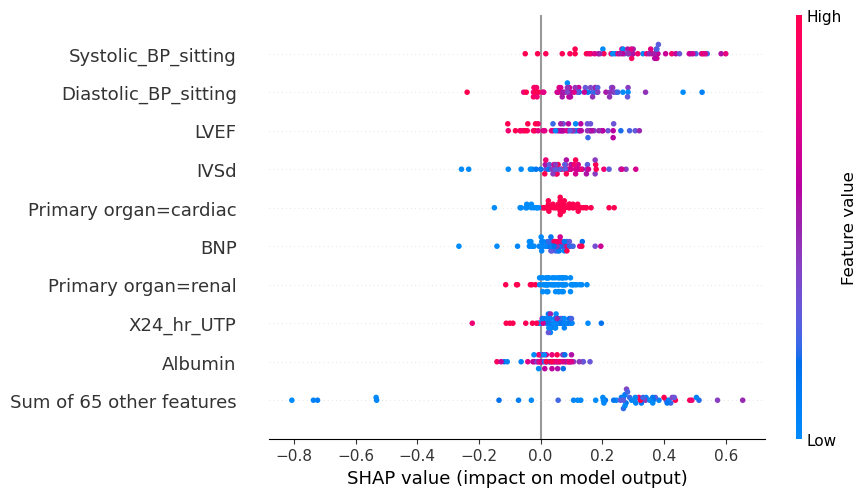

In [73]:
shap.plots.beeswarm(shap_high_values, show=False)